## DQN 2015 keras version (FrozenLake 8x8)

테스트 
 + fit : stack을 쌓아서 학습
 + Replay buffer 사이즈  : 5000
 + 배치 사이즈 변경 : 20->64 샘플링에 성공이 포함되지않을수 있으므로
 + 히든 유닛 변경 : 24->64

In [1]:
import gym
import random
import numpy as np
from collections import deque
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import matplotlib.pyplot as plt


In [2]:
EPISODES = 1000
GAMMA = 0.95           
LEARNING_RATE = 0.001 
MEMORY_SIZE = 5000  
BATCH_SIZE = 64
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.999
EXPLORATION_DECAY_BIG = 0.8
EXPLORATION_DECAY_SMALL = 0.999 

#환경 변수
IDX_ACTION_LEFT = 0
IDX_ACTION_DOWN = 1
IDX_ACTION_RIGHT = 2
IDX_ACTION_UP = 3

STR_ACTION_UP = 'U'
STR_ACTION_DOWN = 'D'
STR_ACTION_RIGHT = 'R'
STR_ACTION_LEFT = 'L'

WALL_UPSIDE = [0,1,2,3,4,5,6,7]
WALL_DOWNSIDE = [56,57,58,59,60,61,62,63] 
WALL_RIGHTSIDE = [7,15,23,31,39,47,55,63]
WALL_LEFTSIDE = [0,8,16,24,32,40,48,56]

GOAL_STATE = 8*8-1
TARGET_UPDATE = 10 # ep 10회 마다 업데이트

class DQNSolver:
    def __init__(self):
        self.observation_space = env.observation_space.n 
        self.action_space = env.action_space.n
        self.epsilon = EXPLORATION_MAX
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.lastest_score = []
        self.episodes = []
        self.steps = []

        self.model = keras.Sequential()
        self.model.add(layers.Dense(64, input_shape=(env.observation_space.n,), activation="relu"))
        self.model.add(layers.Dense(env.action_space.n, activation="linear"))
        self.model.compile(loss="mse", optimizer=optimizers.Adam(lr=LEARNING_RATE))

        self.target_model = keras.Sequential()
        self.target_model.add(layers.Dense(64, input_shape=(env.observation_space.n,), activation="relu"))
        self.target_model.add(layers.Dense(env.action_space.n, activation="linear"))

        # 타깃 모델 초기화
        self.update_target_model()

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def epsilon_decay(self):
        if self.epsilon > EXPLORATION_MIN:
            self.epsilon *= EXPLORATION_DECAY

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def remember(self, state, action, reward, new_state, done):
        self.memory.append((state, action, reward, new_state, done))

    def act(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(self.model.predict(np.identity(env.observation_space.n)[state:state + 1])) # <--- main_model
        return action

    def q_update(self, state, action, reward, new_state, done):
        # 예측값 설정 - 현재 상태에 대한 모델의 큐함수
        target_vector = self.model.predict(np.identity(self.observation_space)[state:state + 1])[0] # <---  : main_model

        # 목표값 설정 - 다음 상태에 대한 타깃 모델의 큐함수 -y 값설정시 업데이트되는 메인 모델이 아닌 타겟모델에서 가져온다.
        if done:
            target_vector[action] = reward            
        else:
            t = self.target_model.predict(np.identity(self.observation_space)[new_state:new_state + 1])
            target_vector[action] = reward + GAMMA * np.max(t) # <--- target_model 

        x = np.identity(self.observation_space)[state:state + 1]
        y = target_vector.reshape(-1, self.action_space)
        self.model.fit(x, y, epochs=1, verbose=0) 

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return

        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, new_state, done in batch:
            self.q_update(state, action, reward, new_state, done) 

    def experience_replay_stacking(self):
        if len(self.memory) < BATCH_SIZE:
            return
        x_stack = np.empty(0).reshape(0, self.observation_space)
        y_stack = np.empty(0).reshape(0, self.action_space)

        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, new_state, done in batch:
            target_vector = self.model.predict(np.identity(self.observation_space)[state:state + 1])[0] 
            if done:
                target_vector[action] = reward            
            else:
                t = self.target_model.predict(np.identity(self.observation_space)[new_state:new_state + 1])
                target_vector[action] = reward + GAMMA * np.max(t) 

            x = np.identity(self.observation_space)[state:state + 1]
            y = target_vector.reshape(-1, self.action_space)
            
            x_stack = np.vstack([x_stack, x])
            y_stack = np.vstack([y_stack, y])

        history = self.model.fit(x_stack, y_stack, epochs=1, verbose=0)
        return history

    
    def report(self, episode, steps, state, elasped_time, lastest_score, reward):

        self.steps.append(steps)
        self.lastest_score.append(lastest_score)
        self.episodes.append(episode)

        min = int(elasped_time/60)  
        sec = int(elasped_time%60)  

        colour = '\033[92m' if reward > 0 else '\033[91m'
        print("episode: " + str(episode).rjust(4) 
        + ' ε: {:.3f}'.format(self.epsilon) 
        + " steps: " + str(steps).rjust(3) 
        + " state: [" + str(state).rjust(2) +"]"
        + ' time: {:02d}'.format(min) 
        + ':{:02d}'.format(sec) 
        + " score: " + str(lastest_score).rjust(2) 
        + ' memory:' + str(len(self.memory)).rjust(4) 
        + f' reward: {colour}' + f"{reward:+.1f}" + '\033[0m')
    
    #학습 결과 시각화
    def display_report(self, b_save=False):
        plt.plot(self.episodes, self.lastest_score, label='Success score')
        plt.plot(self.episodes, self.steps, label='Steps for a goal')
        plt.legend()
        plt.xlabel('episodes')
        plt.show()
    
    #Goal에 들어온 Path인지 확인
    def find_optimal_path(self):
        bfind = False

        state_size = self.observation_space
        action_size = self.action_space
        q_map = np.zeros([state_size, action_size])

        for state in range(state_size): 
            q_value = self.model.predict(np.identity(state_size)[state:state + 1])
            q_map[state] = q_value
            
        optimal_step = 0        
        qvalue_table = np.zeros([q_map.shape[0], q_map.shape[1]])   
        
        for state, q_value in enumerate(q_map):
            q_max = np.amax(q_value) 
            indices = np.nonzero(q_value == q_max)[0]
            qvalue_table[state, indices[0]] = 1
            state += 1

        for state, q_value in enumerate(qvalue_table):
            index = q_value.argmax()

            if optimal_step == state and optimal_step != GOAL_STATE:          
                if index == IDX_ACTION_UP and state not in WALL_UPSIDE:
                    optimal_step -= 8
                elif index == IDX_ACTION_DOWN and state not in WALL_DOWNSIDE:
                    optimal_step += 8
                elif index == IDX_ACTION_RIGHT and state not in WALL_RIGHTSIDE:
                    optimal_step += 1
                elif index == IDX_ACTION_LEFT and state not in WALL_LEFTSIDE:
                    optimal_step -= 1
                else: 
                    pass
        
        if optimal_step == GOAL_STATE:
            bfind = True

        return bfind
        
env = gym.make('FrozenLake-v0',  map_name='8x8', is_slippery=False)

dqn_solver = DQNSolver()
start_time = time.time()
lastest_reward = deque(maxlen=100) 
min_steps = 8*8*2
keep_cnt = 0

np.random.seed(2) 

for episode in range(EPISODES):
    state = env.reset()
    steps = 0
    done = False
    
    while not done:
        steps += 1
        action = dqn_solver.act(state)
        new_state, reward, done, _ = env.step(action)
        #reward = -1.0 if done and reward < 1 else reward  
        reward = 0 if done and reward < 1 else reward  
        
        dqn_solver.remember(state, action, reward, new_state, done) 
        dqn_solver.q_update(state, action, reward, new_state, done) 
        state = new_state
        if done:
            elasped_time = time.time()- start_time
            if reward == 1 :
                lastest_reward.append(1)
            else:
                lastest_reward.append(0)

            lastest_score = sum(lastest_reward)
            
            dqn_solver.report(episode, steps, state, elasped_time, lastest_score, reward)
            dqn_solver.epsilon_decay()
            dqn_solver.experience_replay_stacking()

            # 최단거리로 Goal간경우 
            if reward == 1 and steps <= min_steps:            
                print('------------------->  pre min_steps: ', min_steps, 'steps:', steps)
                if min_steps != steps :
                    min_steps = steps 
                    keep_cnt = 1   # 최단거리 step 갱신
                    print('update > min_steps: ', min_steps, 'keep_cnt:', keep_cnt)
                else:
                    keep_cnt += 1  # 유지되는 횟수 늘림
                    print('keep   > min_steps: ', min_steps, 'keep_cnt:', keep_cnt)

            
    #타깃 모델을 모델의 가중치로 업데이트
    if episode % TARGET_UPDATE == 0:
        dqn_solver.update_target_model()
 
    if lastest_score>1 and keep_cnt>4 and dqn_solver.find_optimal_path():
        print( episode, 'early stopping!!')
        break 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode:    0 ε: 1.000 steps:  26 state: [19] time: 00:04 score:  0 memory:  26 reward: +0.0
episode:    1 ε: 0.999 steps:  16 state: [19] time: 00:06 score:  0 memory:  42 reward: +0.0
episode:    2 ε: 0.998 steps:  34 state: [19] time: 00:11 score:  0 memory:  76 reward: +0.0
episode:    3 ε: 0.997 steps:  23 state: [35] time: 00:20 score:  0 memory:  99 reward: +0.0
episode:    4 ε: 0.996 steps:  11 state: [19] time: 00:27 score:  0 memory: 110 reward: +0.0
episode:    5 ε: 0.995 steps:  92 state: [29] time: 00:46 score:  0 memory: 202 reward: +0.0
episode:    6 ε: 0.994 steps:  36 state: [52] time: 00:57 score:  0 memory: 238 reward: +0.0
episode:    7 ε: 0.993 steps:  18 state: [41] time: 01:05 score:  0 memory: 256 reward: +0.0
episode:    8 ε: 0.992 steps:  13 state: [41] time: 01:13 score:  0 memory: 269 reward: +0.0
episode:    9 ε: 0.991 steps:  13 state: [19] time: 01:20 score:  0 memory: 282 reward: +0.0
episode:   10 ε: 0.990 steps:  65 state: [29] time: 01:35 score:  0 me

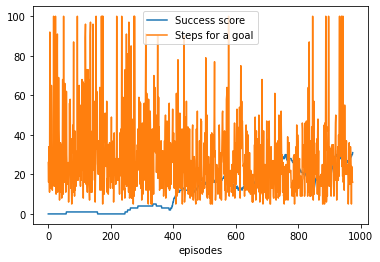

In [3]:
dqn_solver.display_report()

In [5]:
# Q-table 시각화
def print_str_direct(q_value, map_size):
    cnt = 0
    while cnt < len(q_value):
        txt = ''
        for _ in range(map_size):
            # q-value가 실수인 경우 보완
            q = ''.join([str(int(round(e, 0))) for e in q_value[cnt]])
            if q == '1000':
                txt += STR_ACTION_LEFT
            elif q == '0100':
                txt += STR_ACTION_DOWN
            elif q == '0010':
                txt += STR_ACTION_RIGHT
            elif q == '0001':
                txt += STR_ACTION_UP
            else:
                txt += ' '
            txt += ' | '
            cnt += 1
        print(txt)

def get_optimal_path(optimal_q_value, map_size):
    list_optimal_step = []
    optimal_step = 0
    optimal_path = []

    #q-value중 max값을 1로 변경
    qvalue_table = np.zeros([optimal_q_value.shape[0], optimal_q_value.shape[1]])

    for state, q_value in enumerate(optimal_q_value):
        q_max = np.amax(q_value)  # q_value array의 최댓값 반환
        indices = np.nonzero(q_value == q_max)[0]
        qvalue_table[state, indices[0]] = 1
        state += 1

    #print(qvalue_table)

    for state, q_value in enumerate(qvalue_table):
        index = q_value.argmax()

        if optimal_step == state : # 최단 경로 위에 있는 state에 대해 최적경로step을 지정한다.
            list_optimal_step.append(optimal_step)

            if optimal_step == GOAL_STATE:
                q_value = [0,0,0,0]
            else:   
                if index == IDX_ACTION_UP and state not in WALL_UPSIDE:
                    optimal_step -= map_size
                elif index == IDX_ACTION_DOWN and state not in WALL_DOWNSIDE:
                    optimal_step += map_size
                elif index == IDX_ACTION_RIGHT and state not in WALL_RIGHTSIDE:
                    optimal_step += 1
                elif index == IDX_ACTION_LEFT and state not in WALL_LEFTSIDE:
                    optimal_step -= 1
                else: 
                    pass
        else:
            q_value = [0,0,0,0]
        
        optimal_path.append(list(map(int,q_value))) #[1.0, 0.0, 0.0, 0.0] -> [1,0,0,0]

    #print(list_optimal_step)
    #print(optimal_path)

    if optimal_step != GOAL_STATE:
        print("Agent can't find optimal path.")
    return optimal_path

In [6]:
state_size = dqn_solver.observation_space
action_size = dqn_solver.action_space
q_table = np.zeros([state_size, action_size])

for state in range(state_size): 
    q_value = dqn_solver.model.predict(np.identity(state_size)[state:state + 1])
    q_table[state] = q_value
    
optimal_path = get_optimal_path(q_table, 8)
print_str_direct(optimal_path, 8)

D |   |   |   |   |   |   |   | 
R | R | R | R | R | R | R | D | 
  |   |   |   |   |   |   | D | 
  |   |   |   |   |   |   | D | 
  |   |   |   |   |   |   | D | 
  |   |   |   |   |   |   | D | 
  |   |   |   |   |   |   | D | 
  |   |   |   |   |   |   |   | 
